# Hands-on: **Reduced modeling and recovery from uncomplete measurements**

The objective of the practical session is to understand in practice how to create a reduced basis and use it for solving a state estimation inverse problem or a forward problem.

Our base model will be the diffusion equation:
$$-div(a(x) \nabla u(x)) = 1,\quad x \in [0, 1]^2,$$
with homogeneus Dirichlet boundary conditions. We take a piecewise constant diffusion coefficient
$$a_{|D_j} = \theta_j, \quad 1\leq j \leq 4,$$
on the subdomains
$$D_0 = [0, 0.5]^2, D_1 = [0.5, 1]\times[0, 0.5], D_2 = [0, 0.5]\times[0.5, 1], D_3 = [0.5, 1]^2.$$
Thus the solution $u$ depends on a parameter $\theta=(\theta_1,\dots,\theta_4)$ which we pick in the parameter space
$$\Theta= [a_{min}, a_{max}]^4.$$

In the inverse problem case, our goal is to approximate a state $u(x|\theta)$ on the whole domain $x\in [0,1]^2$ for some unknown parameter $\theta$, based on a few point measurements $u(x^i|\theta)$ at chosen points $x^1,\dots,x^m\in [0,1]^2$. We procced in the following way:

Offline stage:

1) **Compute $N$ solutions** (snapshots) $u^1=u(\cdot,\theta^1), \dots, u^N=u(\cdot, \theta^N)$ from a chosen set of parameters $\{\theta^1, \dots ,\theta^N\}\in \Theta^N$.

2) Create a **reduced basis** $V_n$ of dimension $n\leq N$ using the $N$ precomputed snapshots to find the optimal subspace. Optimal in which sense?
- Pick randomly: This new space is generated by the solutions $V_n \subset span\{u^1,\dots,u^N \}$
- Greedy method (optimal with respect to $L_{\infty}$): This new space is generated by the solutions $V_n \subset span\{u^1,\dots,u^N \}$.
- PCA (optimal with respect to $L_{2}$).

Online stage:

3) **Measurements**: obtain $m$ observations $u(x^i,\theta)$ (+noise), $1\leq i \leq m$, of a solution $u(\cdot,\theta)$ whith unknown parameter $\theta$.

4) **State estimation**: construct an approximation $\tilde u\in V_n$ of $u(\cdot,\theta)$ based on these measurements.

5) **Error analysis**: compute the error $\|\tilde u- u(\cdot,\theta)\|_{L^2}$ and study its behaviour depending on the reduced basis and the measurements.


## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
# if in google colab
colab = "/content" in os.getcwd()
if colab:
    # clone Repository ROMHighContrast
    !git clone https://github.com/agussomacal/ROMHighContrast/
    # go to Repository folder
    %cd /content/ROMHighContrast/
    # install requirements
    !pip install matplotlib
    !pip install numpy
    !pip install pathos
    !pip install scikit-learn
    !pip install ipywidgets
    # go to notbooks folder
    %cd /content/ROMHighContrast/src/notebooks/
else:
    if not os.path.exists("./ROMHighContrast") and not "ROMHighContrast" in os.getcwd():
        !git clone https://github.com/agussomacal/ROMHighContrast/

In [3]:
import sys

if colab:
    src_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
    project_path = os.path.abspath(os.path.join(src_path, os.pardir))
    sys.path.insert(1, src_path)
    sys.path.insert(1, project_path)
else:
    if os.path.exists("./ROMHighContrast"):
        src_path = os.path.abspath(os.path.join(os.getcwd(), "ROMHighContrast"))
    elif "ROMHighContrast" in os.getcwd():
        src_path = os.path.abspath(os.path.join(os.getcwd().split("ROMHighContrast")[0], "ROMHighContrast"))
    sys.path.insert(1, src_path)

In [4]:
from typing import List, Tuple, Callable

import numpy as np

from src.lib.VizUtils import plot_solutions_together
from src.lib.SolutionsManagers import SolutionsManager, SolutionsManagerFEM
from src.notebooks.functions4notebooks import *

np.random.seed(42)

In [5]:
# to center plots
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## Parameters and definitions

In [6]:
diffusion_contrast_lower = 1 # a_min
diffusion_contrast_upper = 100 # a_max

#### Display parameters

In [7]:
num_points_per_dim_to_plot = 50 # size of the plotted images
axes_xy_proportions = (3, 3)

#### Defining V space
We will generate the offline solutions with a Galerkin method, in the Finite Element Method space $V$:
- **blocks_geometry**: how many subdomains with varying diffusion coefficients, we set $(2, 2)$ but you can play with other rectangular geometries.
- **N**: the number of points in the FEM discretization per dimension and per block: so if $N=10$ and the geometry is $(2, 2)$ then $(10\cdot 2-1)^2=361=dim(V)$ (the -1 accounts for the fact that points in the boundary do not add degrees of freedom).

In [8]:
# object that knows how to create the solutions to the PDE + projections etc
sm = SolutionsManagerFEM(blocks_geometry=(2,2), N=10, num_cores=1)
print("The space V has dimension {}".format(sm.vspace_dim))

The space V has dimension 361


##### FEM grid and **sm.evaluate_solutions(points, solutions)**

Solutions: 
 [[0.         0.00277778 0.00555556 ... 0.99444444 0.99722222 1.        ]
 [0.37454012 0.95071431 0.73199394 ... 0.94023024 0.57547418 0.38816993]
 [0.64328822 0.45825289 0.54561679 ... 0.73086748 0.93834046 0.18123307]]
Shape: 
 (3, 361)
Number of points:  361
Evaluations: 
 [[0.         0.00277778 0.00555556 ... 0.99444444 0.99722222 1.        ]
 [0.37454012 0.95071431 0.73199394 ... 0.94023024 0.57547418 0.38816993]
 [0.64328822 0.45825289 0.54561679 ... 0.73086748 0.93834046 0.18123307]]


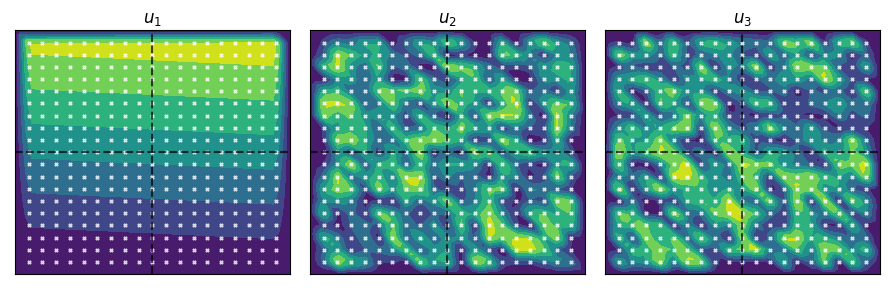

In [9]:
number_of_solutions = 3

# each row is an element v_i of the vector space V (dim(V) = 361 columns)
solutions = [np.linspace(0, 1, sm.vspace_dim)]
solutions = np.vstack((solutions, np.random.uniform(size=(number_of_solutions-1, sm.vspace_dim))))
print("Solutions: \n", solutions)
print("Shape: \n", np.shape(solutions))

x, y = np.meshgrid(sm.points_r[1:-1], sm.points_c[1:-1])
points = np.concatenate([x.reshape((-1,1)), y.reshape((-1,1))], axis=1)
evaluations = sm.evaluate_solutions(points=points, solutions=solutions)
print("Number of points: ", len(points))
print("Evaluations: \n", evaluations)

plot_solutions_together(
    sm,
    diffusion_coefficients=None,
    solutions=solutions,
    num_points_per_dim_to_plot=num_points_per_dim_to_plot,
    contour_levels=7,
    axes_xy_proportions=axes_xy_proportions,
    titles=[r"$u_{}$".format(i+1) for i in range(number_of_solutions)],
    colorbar=False,
    measurement_points=points)

##### **sm.generate_solutions**

Diffusion coefficients shape:  (3, 2, 2) = (number_of_solutions, ) + (2, 2)
Solutions shape:  (3, 361)


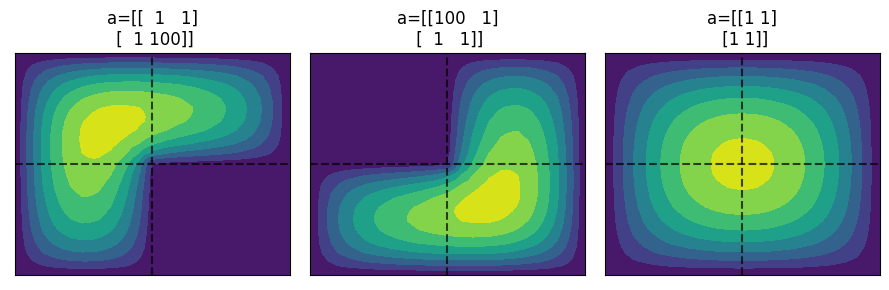

In [10]:
number_of_solutions = 3
number_of_points = 100

# define the matrix of diffusion coefficients \theta for each solution u to be computed.
diffusion_coefficients=np.array([
    [[1, 1],
    [1, 100]],

    [[100, 1],
    [1, 1]],

    [[1, 1],
    [1, 1]],
])
print("Diffusion coefficients shape: ", np.shape(diffusion_coefficients), f"= (number_of_solutions, ) + {sm.blocks_geometry}")

# generate as many solutions as diffusion coefficients matrices given
u = sm.generate_solutions(a2try=diffusion_coefficients[:, ::-1])
print("Solutions shape: ", np.shape(u))
plot_solutions_together(
    sm,
    diffusion_coefficients=np.array(diffusion_coefficients),
    solutions=u,
    num_points_per_dim_to_plot=num_points_per_dim_to_plot,
    contour_levels=7,
    axes_xy_proportions=axes_xy_proportions,
    titles=[r"$u_{}$".format(i) for i in range(number_of_solutions)],
    colorbar=False,
    measurement_points=None)

# Intuition about the problem

#### Play yourself to gain intuition!!!

Change the values of the parameters to see how the solution changes and gain some intuition.

In [11]:
visualize_intuition(sm, diffusion_contrast_lower, diffusion_contrast_upper,
                    num_points_per_dim_to_plot=num_points_per_dim_to_plot,
                    axes_xy_proportions=axes_xy_proportions)

GridspecLayout(children=(FloatSlider(value=50.0, continuous_update=False, description='a[0,0]:', layout=Layout…

Output()

# **_Offline stage_**

In [12]:
number_of_solutions = 200 # N

## 1) **Compute offline solutions**

#### Solution sampling method

To create our offline solutions we need to sample the solution manifold by giving $N$ values of the parameters $\theta$. This can be done in many ways:

1. Uniformly sampling $\theta \in \Theta= [a_{min}, a_{max}]^4$.
2. Making a grid of the four dimensional space $\Theta$.
3. Log-uniform sample $\theta \in \Theta$.
4. ...

The choice may impact the reduced space we will generate afterwards, and the solutions were we are going to test.


In [13]:
def solution_sampling_method_uniform(N, diffusion_contrast_lower, diffusion_contrast_upper, num_blocks) -> np.ndarray:
    """
    return:
    - array of shape (N, number_of_blocks)
    """
    return np.random.uniform(diffusion_contrast_lower, diffusion_contrast_upper, size=(N, num_blocks))

def solution_sampling_method_grid(N, diffusion_contrast_lower, diffusion_contrast_upper, num_blocks) -> np.ndarray:
    # creat the grid
    params = np.array(list(map(np.ravel, np.meshgrid(*[np.linspace(diffusion_contrast_lower, diffusion_contrast_upper, num=int(np.ceil(N**(1/num_blocks))))]*num_blocks)))).T
    # randomly choose n
    ix = np.random.choice(len(params), size=N, replace=False)
    return params[ix, :]

In [14]:
solution_sampling_method = solution_sampling_method_uniform

#### Compute solutions

In [15]:
diffusion_coefficients = solution_sampling_method(number_of_solutions, diffusion_contrast_lower, diffusion_contrast_upper, np.prod(sm.blocks_geometry))
diffusion_coefficients = diffusion_coefficients.reshape((-1,)+sm.blocks_geometry)
solutions = sm.generate_solutions(diffusion_coefficients)

#### Visualize solutions intuition

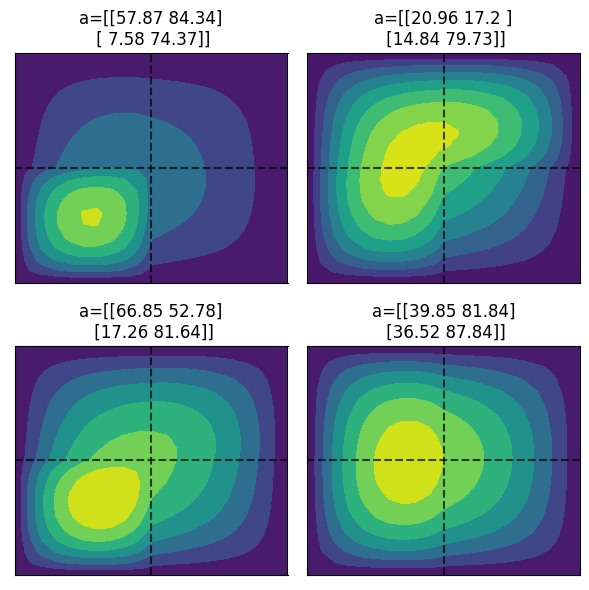

In [16]:
plot_solutions_together(
    sm,
    diffusion_coefficients=diffusion_coefficients[:4][:,::-1],
    solutions=solutions[:4],
    num_points_per_dim_to_plot=100,
    contour_levels=7,
    colorbar=False,
    axes_xy_proportions=axes_xy_proportions
)


---
---

## 2) **Generate Reduced Basis**

Now we are going to create the reduced basis $V_n = span\{v_1, \dots , v_n \}$. For that we will need the previously $N$ precomputed offline solutions and we will need also to code a method to effectively create this reduced basis subspace.


1. **Pick randomly**: a simple way is just to choose randomly $n$ elements from the $N$ snapshots.
2. **PCA (Principal Component Analysis)**: other method can be to do PCA with the $N$ solutions and choose the first eigenvectors to create our basis. Note that in this case the base elements will probably not be solutions to the PDE. This method tries to minimize the $L_{2}$ norm.
3. **Greedy**: Use the greedy algorithm to incrementally create a basis that minimizes the $L_\infty$ norm over the set of $N$ precomputed solutions.
4. For comparison, we can also use a basis of lower degree polynomials, without taking into account the physical model.
5. ...


In [17]:
# Scheme for a generic reduced_basis_generator method.
def reduced_basis_generator(solutions_offline: List[np.ndarray], number_of_reduced_base_elements: int,
                            *args, **kwargs) -> List[np.ndarray]:
    """

    solutions_offline: List of solutions precalculated in an offline stage: shape = (N, dim(V)).
    number_of_reduced_base_elements: n

    The output is a list of n vectors forming the basis: shape = (n, dim(V)).
    """
    ...
    return basis


def reduced_basis_generator_first_n(solutions_offline: List[np.ndarray], number_of_reduced_base_elements: int) -> List[np.ndarray]:
    # if the original offline solutions are random this will also be random.
    return solutions_offline[:number_of_reduced_base_elements]

#### Exercise

Implement the following algorithms for building the reduced basis:
- **Uniformly random**
- **PCA**
- **greedy** .

In [18]:
def reduced_basis_generator_random(solutions_offline: List[np.ndarray], number_of_reduced_base_elements: int, seed=42) -> List[np.ndarray]:
    np.random.seed(seed)
    # TO IMPLEMENT
    ...
    return basis


def reduced_basis_generator_pca(solutions_offline: List[np.ndarray], number_of_reduced_base_elements: int) -> List[np.ndarray]:
    # hint: look at PCA from sklearn library or svd from numpy and scipy.
    # TO IMPLEMENT
    ...
    return basis


def reduced_basis_generator_greedy(solutions_offline: List[np.ndarray], number_of_reduced_base_elements: int) -> List[np.ndarray]:
    # hint:
    # add the vector (solution) with maximum distance to the actual space by calculating the differences
    # between the solutions and the projections to the actual space.
    # For the projection solve the least square problem, you can use np.linalg.lstsq
    # TO IMPLEMENT
    ...
    return basis

#### Solutions to Reduced Basis generators methods:

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# ---------- random algorithm ---------- #
def reduced_basis_generator_random(solutions_offline: List[np.ndarray], number_of_reduced_base_elements: int, seed=42) -> List[np.ndarray]:
    np.random.seed(seed)
    chosen_indexes = np.random.choice(len(solutions_offline), size=number_of_reduced_base_elements, replace=False)
    return [solutions_offline[ix] for ix in chosen_indexes]


# ---------- pca algorithm ---------- #
def reduced_basis_generator_pca(solutions_offline: List[np.ndarray], number_of_reduced_base_elements: int) -> List[np.ndarray]:
    transformer = StandardScaler(with_mean=True, with_std=True) # to center by mean and scale by variance.
    # the mean and std is taken along the columns which means on each of the dimensions of the V space.
    basis = PCA(n_components=number_of_reduced_base_elements).fit(transformer.fit_transform(solutions_offline)).components_
    # we need to come back to the original space
    return transformer.inverse_transform(basis)

def reduced_basis_generator_pca_noznorm(solutions_offline: List[np.ndarray], number_of_reduced_base_elements: int) -> List[np.ndarray]:
    return PCA(n_components=number_of_reduced_base_elements).fit(solutions_offline).components_


# ---------- greedy algorithm ---------- #
def get_function_norm(norm="l2"):
    """
    Get a function that calculates the desired norm (l2 or h10) when applied on a list of elements of the V space.
    """
    if norm == "l2":
        f_norm = sm.l2norm
    elif norm == "h10":
        f_norm = sm.H10norm
    else:
        raise Exception(f"Norm {norm} not implemented.")
    return f_norm

assert get_function_norm("l2") == sm.l2norm

def reduced_basis_generator_greedy(solutions_offline: List[np.ndarray], number_of_reduced_base_elements: int, function_norm: Callable) -> List[np.ndarray]:
    basis = [solutions_offline[np.argmax(function_norm(solutions_offline), axis=0)]]
    for _ in range(1, number_of_reduced_base_elements):
        x = np.linalg.lstsq(np.transpose(basis), np.transpose(solutions_offline), rcond=None)[0]
        next_element = np.argmax(function_norm((np.transpose(solutions_offline) - np.transpose(basis) @ x).T))
        basis.append(solutions_offline[next_element])
    return basis

In [20]:
max_vn_dim = 20

reduced_basis_dict = {
    "PCA": reduced_basis_generator_pca(solutions, max_vn_dim),
    "PCA_no_scale": reduced_basis_generator_pca(solutions, max_vn_dim),
    "Greedy_l2": reduced_basis_generator_greedy(solutions, max_vn_dim, function_norm=get_function_norm("l2")),
    "Greedy_h10": reduced_basis_generator_greedy(solutions, max_vn_dim, function_norm=get_function_norm("h10")),
    "Random": reduced_basis_generator_random(solutions, max_vn_dim)
}

# **_Online stage_**

## 3) **Measurements**

Now we are ready to face a "real world" problem which consist on measuring (possibly with noise) our system at some points. These measurements can be specifically chosen points or just random observations. So we need to specify how these $m$ observations are going to be obtained:
1. Sampling uniformly random $m$ points in the domain.
2. Measures at points placed on a grid.
3. Sample only in one of the quadrants.
4. Adding more samples near the intersections of quadrants.
5. Sample randomly according to some other distribution.
6. Is there an optimal sampling strategy? [A. Cohen; G. Migliorati. Optimal weighted least-squares methods. The SMAI Journal of computational mathematics, Volume 3 (2017), pp. 181-203.](https://smai-jcm.centre-mersenne.org/articles/10.5802/smai-jcm.24/) [M. Dolbeault, PhD thesis: Optimal Sampling and Model Order Reduction](https://cloud.ljll.math.upmc.fr/owncloud/index.php/s/xuVVzqBNeutOKpa)

#### Define measurements sampling method

In [21]:
def measurements_sampling_method(number_of_measures: int, xlim: Tuple[float, float], ylim: Tuple[float, float]) -> np.ndarray:
    """
    Given the number_of_measures=m and the boundaries of the domain xlim, ylim
    return a list of m points [(x1, y1), ... (xm, ym)] sampeled from the domain where measurements will be taken (by some kind of sensor)
    measurement_points  shape = (m, 2)
    """

    ...

    return measurement_points

#### Exercise

Implement methods to sample m points in the domain which will be the sensor locations.
- sample **uniformly random**
- sample on a **grid**

In [22]:
def measurements_sampling_method_uniform(number_of_measures, xlim, ylim, seed=42, **kwargs) -> np.ndarray:
    np.random.seed(seed)
    # TO IMPLEMENT

    ...

    return measurement_points

def measurements_sampling_method_grid(number_of_measures, xlim, ylim, seed=42, **kwargs) -> np.ndarray:
    n_per_dim = int(np.ceil(np.sqrt(number_of_measures)))
    # TO IMPLEMENT

    ...

    return measurement_points

#### Solutions to excersice on sampling measurements

In [23]:
def measurements_sampling_method_uniform(number_of_measures, xlim, ylim, seed=42, **kwargs) -> np.ndarray:
    np.random.seed(seed)
    return np.hstack((np.random.uniform(*xlim, size=(number_of_measures, 1)),
                      np.random.uniform(*ylim, size=(number_of_measures, 1))))

def measurements_sampling_method_grid(number_of_measures, xlim, ylim, seed=42, **kwargs) -> np.ndarray:
    n_per_dim = int(np.ceil(np.sqrt(number_of_measures)))
    x, y = np.meshgrid(*[np.linspace(*xlim, num=n_per_dim+2)[1:-1],
                         np.linspace(*ylim, num=n_per_dim+2)[1:-1]])
    measurement_points = np.concatenate([x.reshape((-1,1)), y.reshape((-1,1))], axis=1)

    # keep only m points.
    np.random.seed(seed)
    ix = np.random.choice(len(measurement_points), size=number_of_measures, replace=False)
    return measurement_points[ix]

from scipy.stats import qmc


def measurements_sampling_method_sobol_points(number_of_measures, xlim, ylim, seed=42, **kwargs) -> np.ndarray:
    # sobol points
    measurement_points = qmc.Sobol(d=2, scramble=True).random_base2(m=int(np.ceil(np.log2(number_of_measures))))
    # translate and shrink to be inside the domain
    measurement_points[:, 0] = measurement_points[:, 0] * (np.diff(xlim)) + xlim[0]
    measurement_points[:, 1] = measurement_points[:, 1] * (np.diff(ylim)) + ylim[0]
    # get exactly number_of_measures quantity
    return measurement_points[np.random.choice(len(measurement_points), size=number_of_measures, replace=False)]


def measurements_sampling_method_latin_square(number_of_measures, xlim, ylim, seed=42, **kwargs) -> np.ndarray:
    # choose points in a matrix so no one share rows nor columns with respect to others.
    measurement_points = np.transpose([np.random.choice(number_of_measures, size=number_of_measures, replace=False),
                                       np.random.choice(number_of_measures, size=number_of_measures, replace=False)])
    # put in [0, 1] interval
    measurement_points = measurement_points / number_of_measures
    # add a random perturbation inside the square
    measurement_points += np.random.uniform(size=(number_of_measures, 2)) / number_of_measures
    # translate and shrink to be inside the domain
    measurement_points[:, 0] = measurement_points[:, 0] * np.diff(xlim) + xlim[0]
    measurement_points[:, 1] = measurement_points[:, 1] * np.diff(ylim) + ylim[0]
    return measurement_points


from src.lib.ReducedBasis import orthonormalize_base


def inverse_christoffel_function(basis, sm, measurement_points):
    basis = orthonormalize_base(basis)
    measurements_reduced_basis = sm.evaluate_solutions(measurement_points, basis)
    weights = np.sum(measurements_reduced_basis**2, axis=0)
    return weights

def measurements_sampling_method_optimal(number_of_measures, xlim, ylim, basis, sm, seed=42, discretization=5, **kwargs) -> np.ndarray:
    """
    param: discretization to make a discretization of the domain and correspondingly the measure so we can calculate
    estimate the probability on each point of the domain and correspondigly the weights.

    Note: this method should be cupled with the weighted_state_estimation method
    Note 2: to check if it is correct the implementation
    """
    np.random.seed(seed)
    n_per_dim = int(discretization*np.sqrt(number_of_measures))
    x, y = np.meshgrid(*[np.linspace(*xlim, num=n_per_dim), np.linspace(*ylim, num=n_per_dim)])
    measurement_points = np.concatenate([x.reshape((-1,1)), y.reshape((-1,1))], axis=1)

    weights = inverse_christoffel_function(basis, sm, measurement_points)
    weights /= np.sum(weights)
    # sample using the measure given by the inverse_christoffel_function of the basis.
    return measurement_points[np.random.choice(len(measurement_points), size=number_of_measures, p=weights, replace=False)]

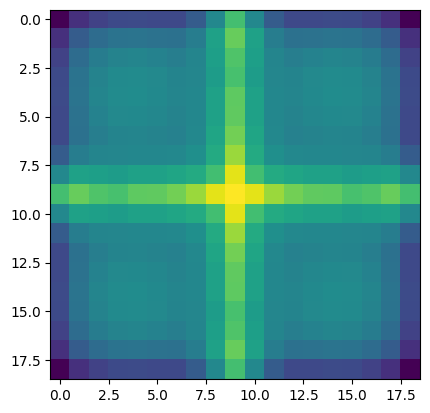

In [24]:
# plot of christoffel function
x, y = np.meshgrid(sm.points_r[1:-1], sm.points_c[1:-1])
measurement_points = np.concatenate([x.reshape((-1,1)), y.reshape((-1,1))], axis=1)
weights = inverse_christoffel_function(reduced_basis_dict["PCA"], sm, measurement_points)
weights /= np.sum(weights)


plt.imshow(np.log10(weights.reshape(19, 19)))

In [25]:
measurements_sampling_method_dict = {
    "Random": measurements_sampling_method_uniform,
    "Grid": measurements_sampling_method_grid,
    "Optimal": measurements_sampling_method_optimal,
    "Sobol-points": measurements_sampling_method_sobol_points,
    "Latin-Square": measurements_sampling_method_latin_square,
}

## 4) **State Estimation**

Having now the measurements ($\ell_i(u)=u(x_i)$) and the reduced basis we can find

1. **Least-squares method**: which is the element $v^* \in V_n=\underset{j=1,\dots,n}{span}\{\phi_j\}$ that better fits (in some norm, like $l_2$) the observations.
$$
v = \sum^n_{j=1} c_j \phi_j \quad \longrightarrow \quad \ell_i(v)=v(x_i) = \sum^n_{j=1} c_j \phi_j(x_i)\\
c^* = \underset{c}{arg\,min} ||u(x_i)-v(x_i)||_{l_2} = \underset{c}{arg\,min} \left( u(x_i)-\sum^n_{j=1} c_j \phi_j(x_i) \right)^2 \\
v^* = \sum^n_{j=1} c^*_j \phi_j
$$
we end up having to solve a linear system $Ac=b$ where $b_i=u(x_i)$ are the measurement values, $A_{ij}=\phi_j(x_i)$ is a rectangular matrix $m\times n$ (whose $j$-th column corresponds to the evaluations of the $j$-th element of the reduced basis at points $x_1,\dots,x_n$), and $c$ is the coefficients (seen in the basis $V_n$) of the element in $V_n$ that better fits the observations.
2. **PBDW method**: To the previous approach we can add a correction on $v^*$ to account for the discrepancy on the measurement points moving on the orthogonal of the measurements space $W=\underset{i=1,\dots,m}{span}{w_i}$ (with $w_i$ the Riesz representers associated to the linear functionals $\ell_i$):
$$u^*=v^*+ P_W(u) - P_W(v^*)\\
P_W(v^*) = \sum_i \sum_j \phi_j(x_i) w_i = \sum_i \sum_j <w_i, \phi_j> w_i\\
P_W(u) = \sum_i u(x_i) w_i.$$
So the question becomes how to obtain the Riesz representers.
3. The previous methods are linear and even though they work well for our example problem in other situations they may fail (particularly on transport dominated problems). For this reason, effort has been put in searching for non-linear alternatives that could work even in those cases:
    - Inspired from [Operator inference for non-intrusive model reduction with quadratic manifolds](https://arxiv.org/abs/2205.02304): instead of writing the approximate solution as the linear combination of basis elements we will add non linear interactions:
$$v^*(x) = \sum^n_{j=1} c_j \phi_j(x) + \sum_j^n \sum_k^n d_{jk}\phi_j(x)\phi_k(x).$$
The dimension $n$ of the space has not changed but we have added more expressive power by allowing non linear (polynomial) interactions. The coefficients $c_j,d_{jk}$ can be also found by linear regression if we redefine the matrix $A$ of the first problem to be a $m \times (n+n^2)$ matrix containing the linear and non-linear interactions between basis elements. We can see immediately that this approach will demand an increasing number of measurements as $m > n+n^2$ to make the system determined.

In [26]:
def state_estimation_fitting_method(measurement_points: np.ndarray, measurements: np.ndarray, reduced_basis: List[np.ndarray], **kwargs) -> np.ndarray:
    """
    - measurement_points: output of last section, the location of seansors from which the measurements will be
    taken: (m, 2)
    - measurements: the actual observed measurements at the defined location points for k different
    unknown solutions u( |\theta) to be approximated: shape = (k, m)
    - reduced_basis: List of basis elements: (n, dim(V))

    return
    - approximate_solutions: shape = (k, dim(V))
    """

    ...

    return approximate_solutions

#### Exercise

Implement two linear inverse methods:
- **Least-squares** method to find the projection on the Vn space
- **PBDW** by applying the correction to the previous method.
- **Non linear (Polynomial) method**:

In [27]:
def state_estimation_fitting_method_least_squares(measurement_points, measurements, reduced_basis: List, **kwargs):
    # TO IMPLEMENT
    ...
    return approximate_solutions



def pbdw_correction(measurement_points, measurements, approximate_solutions, sm: SolutionsManager, **kwargs):
    # TO IMPLEMENT
    ...
    return approximate_solutions


def state_estimation_fitting_method_pbdw(measurement_points, measurements, reduced_basis: List, **kwargs):
    approximate_solutions = state_estimation_fitting_method_least_squares(measurement_points, measurements, reduced_basis)
    approximate_solutions = pbdw_correction(measurement_points, measurements, approximate_solutions, sm)
    return approximate_solutions


def polynomial_state_estimation_fitting_method_least_squares(measurement_points, measurements, reduced_basis: List, degree=2, **kwargs):
    # hint: look at PolynomialFeatures, LinearRegression and Pipeline from sklearn.
    # TO IMPLEMENT
    ...
    return approximate_solutions

#### Solutions to State estimation

In [28]:
def state_estimation_fitting_method_least_squares(measurement_points, measurements, reduced_basis: List, **kwargs):
    # evaluate the reduced basis elements in the measurement points to get the matrix A: the rectangular matrix mxn
    # whose columns corresponds to the m evaluations of each element of the reduced basis in the measurement points.
    measurements_reduced_basis = sm.evaluate_solutions(measurement_points, reduced_basis)
    # solves the linear least squares problem Ax = b where b is the measurements which is the same as finding the
    # coordinates (coeficients) of the element in Vn space which is the proyection P_Vn u in l2.
    coefficients = np.linalg.lstsq(measurements_reduced_basis.T, measurements.T, rcond=-1)[0]
    # build the approximation
    approximate_solutions = coefficients.T @ np.array(reduced_basis)
    return approximate_solutions


def pbdw_correction(measurement_points, measurements, approximate_solutions, sm, **kwargs):
    # riesz representers in l2 norm
    riesz = sm.evaluate_solutions(points=measurement_points, solutions=np.eye(sm.vspace_dim))  # (N, m)
    # solution u projection onto the W space spanned by the riesz representers.
    pwu = measurements @ riesz.T  # (k, N)
    # approximations in Vn space projection onto the W space spanned by the riesz representers.
    # (approximate_solutions @ riesz) is the iner product with the riesz representers, which means the evaluation.
    pw_vn = (approximate_solutions @ riesz) @ riesz.T
    # correction substracting projection of vn on W and adding the one asociated to the true solution.
    approximate_solutions = approximate_solutions + pwu - pw_vn
    return approximate_solutions


def state_estimation_fitting_method_pbdw(measurement_points, measurements, reduced_basis: List, **kwargs):
    approximate_solutions = state_estimation_fitting_method_least_squares(measurement_points, measurements, reduced_basis)
    approximate_solutions = pbdw_correction(measurement_points, measurements, approximate_solutions, sm)
    return approximate_solutions


def state_estimation_fitting_method_weighted_least_squares(measurement_points, measurements, reduced_basis: List, **kwargs):
    """

    Note: this method should be cupled with the optimal sampling strategy to make the best out of it
    Note 2: to check if it is correct the implementation
    """
    # same as state_estimation_fitting_method_least_squares but adding weights
    measurements_reduced_basis = sm.evaluate_solutions(measurement_points, reduced_basis)
    weights = 1/inverse_christoffel_function(reduced_basis, sm, measurement_points)
    coefficients = np.linalg.lstsq(measurements_reduced_basis.T * weights[:, np.newaxis],
                                   measurements.T * weights[:, np.newaxis], rcond=-1)[0]
    approximate_solutions = coefficients.T @ np.array(reduced_basis)
    return approximate_solutions


from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LassoCV, MultiTaskLassoCV, LassoLarsIC

def polynomial_state_estimation_fitting_method_least_squares(measurement_points, measurements, reduced_basis: List, degree=2, **kwargs):
    measurements_reduced_basis = sm.evaluate_solutions(measurement_points, reduced_basis)
    model = Pipeline([('PF', PolynomialFeatures(degree=degree, include_bias=False)),
                      ('LR', LinearRegression(fit_intercept=False))])
    # regularization to avoid overfiting when number of parameters approaches number of samples
    # model = Pipeline([('PF', PolynomialFeatures(degree=degree, include_bias=False)),
    #                   ('LR', MultiTaskLassoCV(fit_intercept=False))])
    # model = Pipeline([('PF', PolynomialFeatures(degree=degree, include_bias=False)),
    #                   ('LR', LassoLarsIC(fit_intercept=False))])

    model.fit(measurements_reduced_basis.T, measurements.T)
    # coefficients = model.steps[-1][1].coef_
    approximate_solutions = model.predict(np.array(reduced_basis).T).T
    return approximate_solutions


# Double-descent tweeter thread
# https://threadreaderapp.com/thread/1292293102103748609.html

In [29]:
state_estimation_method_dict = {
    "least-squares": state_estimation_fitting_method_least_squares,
    "PBDW": state_estimation_fitting_method_pbdw,
    "polynomial-least-squares": polynomial_state_estimation_fitting_method_least_squares,
    "weighted-least-squares": state_estimation_fitting_method_weighted_least_squares
}

#### Visualize approximations

In [30]:
vizualize_approximations(sm, measurements_sampling_method_dict, reduced_basis_dict, state_estimation_method_dict,
                             diffusion_contrast_lower, diffusion_contrast_upper, max_vn_dim,
                             num_points_per_dim_to_plot=50, axes_xy_proportions=(3, 3))

GridspecLayout(children=(GridspecLayout(children=(FloatSlider(value=50.0, continuous_update=False, description…

Output()

## 5) **Reduced basis error**

Now that we have all the steps of the state estimation pipeline we can ask ourselves how behaves empirically the approximation error of the state estimation problem when we:
1. Increase the number of basis elements $n$.
2. Change the number of measurements $m$.
3. Add noise to the measurements (by specifying the $\sigma$ of a normally distributed noise $N(0, \sigma)$).
4. Change the reduced basis.
5. Change the measurements sampling method.
6. ...

In [31]:
visualize_convergence(sm, solutions, measurements_sampling_method_dict, reduced_basis_dict,
                          state_estimation_method_dict, max_vn_dim)

GridspecLayout(children=(Dropdown(description='Error metric: ', layout=Layout(grid_area='widget001'), options=…

Output()

In [32]:
visualize_state_estimation_methods(sm, solutions, measurements_sampling_method_dict, reduced_basis_dict,
                                       state_estimation_method_dict, max_vn_dim)

GridspecLayout(children=(Dropdown(description='Error metric: ', layout=Layout(grid_area='widget001'), options=…

Output()

In [33]:
visualize_samplers(sm, solutions, measurements_sampling_method_dict, reduced_basis_dict,
                                       state_estimation_method_dict, max_vn_dim)

GridspecLayout(children=(Dropdown(description='Error metric: ', layout=Layout(grid_area='widget001'), options=…

Output()

# Acknowldgements

Special thanks to Matthiew Dolbeault who contributed to the first version of the notebook as well as to the finite element solver hidden inside SolutionManager object.

# Inverse problems pipeline (to look later at home with the beverage of your choice and if you feel motivated)

The following code-cells put together all the pieces we have been developing so far in a single Pipeline with the help of [PerplexityLab](https://github.com/agussomacal/PerplexityLab) python package to **parallelize**, explore different **configurations of parameters**, quickly **visualize** results and calculate the **carbon footprint** of the executions.

In [49]:
!pip install git+https://github.com/agussomacal/PerplexityLab

  Cloning https://github.com/agussomacal/PerplexityLab to /tmp/pip-req-build-2xh6i4pp
  Running command git clone --filter=blob:none --quiet https://github.com/agussomacal/PerplexityLab /tmp/pip-req-build-2xh6i4pp
  Resolved https://github.com/agussomacal/PerplexityLab to commit 6cd76ec74cb71000807a46937b3471e879e2e2c7
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 70.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.4 MB/s eta 0:00:00
  Created wheel for PerplexityLab: filename=PerplexityLab-0.0.1b0-py3-none-any.whl size=28060 sha256=8460e767b01f4bcb0cc07d333fd4c92c9f46ea9c326f66e7cac149c30bf3bd6d
  Stored in directory: /tmp/pip-ephem-wheel-cache-p275er2x/wheels/58/2

In [50]:
from PerplexityLab.DataManager import DataManager, JOBLIB
from PerplexityLab.LabPipeline import LabPipeline, FunctionBlock
from PerplexityLab.miscellaneous import NamedPartial

### Define Pipeline

In [51]:
def define_fem(blocks_geometry, n_per_dim_per_block):
    return {
        "sm": SolutionsManagerFEM(blocks_geometry=blocks_geometry, N=n_per_dim_per_block, num_cores=1)
    }


def manifold_sampler_decorator(solution_sampling_method):
    def solutions_generator(number_of_solutions, sm):
        diffusion_coefficients = solution_sampling_method(
            number_of_solutions,
            diffusion_contrast_lower=diffusion_contrast_lower,
            diffusion_contrast_upper=diffusion_contrast_upper,
            num_blocks=np.prod(sm.blocks_geometry))
        diffusion_coefficients = diffusion_coefficients.reshape((-1,)+sm.blocks_geometry)
        solutions = sm.generate_solutions(diffusion_coefficients)
        return {
            "diffusion_coefficients": diffusion_coefficients,
            "solutions": solutions
        }
    solutions_generator.__name__ = solution_sampling_method.__name__
    return solutions_generator


def basis_generator_decorator(basis_generator):
    def reduced_basis_generator(max_vn_dim, sm):
        return {
            "basis": basis_generator(solutions_offline=solutions, number_of_reduced_base_elements=max_vn_dim),
        }
    return reduced_basis_generator


def sensor_placement_decorator(method):
    def sensor_placement_method(m, sm, basis):
        return {"measurement_points": method(m, sm.x_domain, sm.y_domain, basis=basis, sm=sm)}
    return sensor_placement_method


def measure(sm, measurement_points, solutions, noise):
    return {"measurements": sm.evaluate_solutions(measurement_points, solutions) + np.random.normal(scale=noise)}


def state_estimation_decorator(inverse_problem_method):
    def state_estimation_method(measurement_points, measurements, basis, sm, n):
        return {
            "approximate_solutions": inverse_problem_method(measurement_points=measurement_points,
                                                            measurements=measurements,
                                                            reduced_basis=basis[:n], sm=sm),
        }
    return state_estimation_method


# ---------- OFFLINE STAGE ----------- #
pipeline = LabPipeline()
pipeline.define_new_block_of_functions("define_V_space", define_fem)
pipeline.define_new_block_of_functions("sample_manifold", manifold_sampler_decorator(solution_sampling_method_uniform))
pipeline.define_new_block_of_functions("basis_generator",
                                       FunctionBlock("PCA", basis_generator_decorator(reduced_basis_generator_pca)),
                                       FunctionBlock("PCA_noscale", basis_generator_decorator(reduced_basis_generator_pca_noznorm)),
                                       FunctionBlock("Random", basis_generator_decorator(reduced_basis_generator_random)),
                                       FunctionBlock("Greedy-l2", basis_generator_decorator(NamedPartial(reduced_basis_generator_greedy, function_norm=get_function_norm(norm="l2")))),
                                       FunctionBlock("Greedy-h10", basis_generator_decorator(NamedPartial(reduced_basis_generator_greedy, function_norm=get_function_norm(norm="h10")))),
                                       )
pipeline.define_new_block_of_functions("sensor_placement",
                                       FunctionBlock("Random", sensor_placement_decorator(measurements_sampling_method_uniform)),
                                       FunctionBlock("Grid", sensor_placement_decorator(measurements_sampling_method_grid)),
                                       FunctionBlock("Optimal", sensor_placement_decorator(measurements_sampling_method_optimal)),
                                       FunctionBlock("Optimal", sensor_placement_decorator(measurements_sampling_method_latin_square)),
                                       FunctionBlock("Optimal", sensor_placement_decorator(measurements_sampling_method_sobol_points))
                                       )

# ---------- ONLINE STAGE ----------- #
pipeline.define_new_block_of_functions("take_measurements", measure)
pipeline.define_new_block_of_functions("state_estimation",
                                       FunctionBlock("LS", state_estimation_decorator(state_estimation_fitting_method_least_squares)),
                                       FunctionBlock("PBDW", state_estimation_decorator(state_estimation_fitting_method_pbdw)),
                                       FunctionBlock("WLS", state_estimation_decorator(state_estimation_fitting_method_weighted_least_squares)),
                                       FunctionBlock("Poly2LS", state_estimation_decorator(polynomial_state_estimation_fitting_method_least_squares)))



### Run experiments

In [58]:
# DataManager generates an object that will manage the data generated through the expeeriments:
# - load (if previous computations have been done already).
# - save
# - manage access to relevant variables in a pandas-like form dm["n"] would give the list of values for parameter n used so far as input of the experiments.
dm = DataManager(path=os.getcwd(), name="Experiments", format=JOBLIB, trackCO2=True)
# The pipeline will be executed on as many cores as specified and only not yet done experiments will be computed.
pipeline.execute(
    datamanager=dm, num_cores=-1, forget=False, save_on_iteration=1,
    blocks_geometry=[(2, 2)],
    n_per_dim_per_block=[10],
    number_of_solutions=[100],
    max_vn_dim=[max_vn_dim],
    n=list(range(1, 10)),
    m=[50],
    noise=[0]
    )
# get an estimation of CO2 consumption during all the executions accumulated so far today and in previous days.
print(f"CO2 emissions of this experiment: {dm.CO2kg :.2f}kg")

 -> duracion Loading dataset: 0.01s


 Experiments for define_V_space already done, skipping.


 Experiments for sample_manifold already done, skipping.


 Experiments for basis_generator already done, skipping.


Doing sensor_placement...: 3it [00:00, 14.58it/s]
Doing take_measurements...: 8it [00:01,  5.29it/s]
Doing state_estimation...: 216it [01:09,  3.13it/s]


CO2 emissions of this experiment: 0.00kg


### Explore

In [59]:
# available variables to plot
dm.columns

{'approximate_solutions',
 'basis',
 'basis_generator',
 'blocks_geometry',
 'define_V_space',
 'diffusion_coefficients',
 'm',
 'max_vn_dim',
 'measurement_points',
 'measurements',
 'n',
 'n_per_dim_per_block',
 'noise',
 'number_of_solutions',
 'sample_manifold',
 'sensor_placement',
 'sm',
 'solutions',
 'state_estimation',
 'take_measurements'}

Plot /content/ROMHighContrast/src/notebooks/Experiments/plot_lineplot_l2_error_vs_n_by_model.png


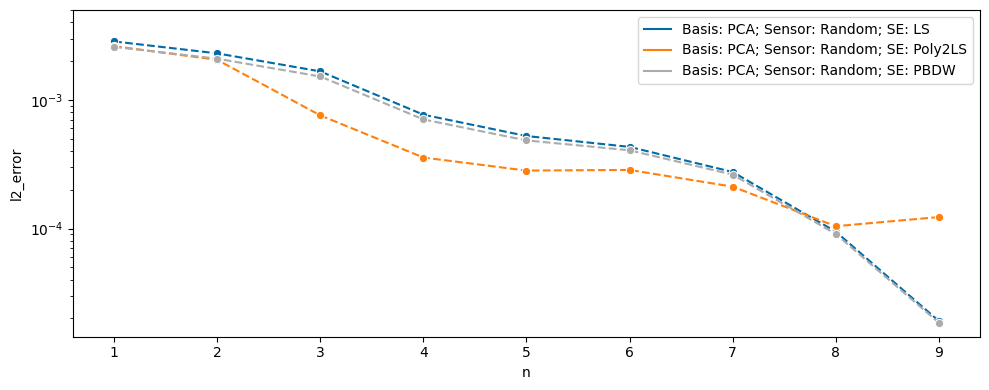

 -> duracion Plot /content/ROMHighContrast/src/notebooks/Experiments/plot_lineplot_l2_error_vs_n_by_model.png
: 0.55s
CO2 emissions of this experiment: 0.00kg


In [60]:
%matplotlib inline
from PerplexityLab.visualization import generic_plot
import seaborn as sns

# plots y variable versus x variable splitig in labels by the variable specified on label.
# variables are initialy those available in the DataManager object but new ones can be created
# inmediately by just writing them as a function depending on existing variables (ex: l2_error or model).
generic_plot(
    data_manager=dm,
    x="n",
    l2_error=lambda solutions, approximate_solutions: np.mean(np.sqrt(np.mean((solutions - approximate_solutions) ** 2, axis=-1))),
    y="l2_error",
    model=lambda basis_generator, sensor_placement, state_estimation: f"Basis: {basis_generator}; Sensor: {sensor_placement}; SE: {state_estimation}",
    label="model",
    basis_generator=["PCA"],
    sensor_placement=["Random"],
    plot_func=NamedPartial(sns.lineplot, marker="o", linestyle="dashed"),
    log="y",
    ylim=(None, 5e-3),
    xlim=None,
    axes_by=[],
    plot_by=[],
    savefig=False,
    axes_xy_proportions=(10, 4)
    )
print(f"CO2 emissions of this experiment: {dm.CO2kg :.2f}kg")